In [13]:
import numpy as np
import copy
import pandas as pd
from gym_ur.game_of_ur import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
plt.style.use('ggplot')

In [2]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_ids):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_action = np.argmax(q_curr)
        if best_action in movable_piece_ids.keys():
            return movable_piece_ids[best_action]
        
    return np.random.choice(possible_actions)

In [3]:
# create environment
env = GoUrEnv(3)

In [4]:
def updateMCValues(Q_func, episode_transitions, gamma, alpha):
    '''
    Updates the Q-function according to the given episode transitions.
    
    Args:
        Q_func: A dictonary mapping state -> action values.
        episode_transitions: A list of (state, action, reward) tuples describing the episode.
        gamma: The discount factor.
        alpha: The stepsize.
        
    Returns:
        The updated Q-function.
    '''
    G = 0
    episode_transitions = episode_transitions[::-1]
    for state, action, reward in episode_transitions:
        G = reward + (gamma * G)
        Q_func[state][action] += (alpha * (G - Q_func[state][action])) 

    return Q_func

In [27]:
def train_mc_agent(env, num_episodes, eps=0.1, gamma=1.0, alpha=0.1, logging=False):
    player1 = 0
    player2 = 1
    init_q_value = 0.0
    Q_func_1 = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    Q_func_2 = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    
    episode_rewards_p1 = [0.0]
    episode_rewards_p2 = [0.0]
    for curr_episode in range(num_episodes):
        episode_transitions_p1 = list()
        episode_transitions_p2 = list()
        state = env.reset()
        is_done = False
        if logging:
            print(curr_episode)
            
        while True:
            # player 1 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q_func_1[state], eps, possible_actions, movable_piece_ids)
                new_state, reward_p1, done, _ = env.step(action)
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                episode_transitions_p1.append((state, action['piece_id'][1], reward_p1))
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q_func_2[state], eps, possible_actions, movable_piece_ids)
                new_state, reward_p2, done, _ = env.step(action)
                episode_transitions_p2.append((state, action['piece_id'][1], reward_p2))
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            if logging:
                print(state, reward, done)
        
        episode_rewards_p1[-1] =+ reward_p1
        episode_rewards_p1.append(0.0)
        
        episode_rewards_p2[-1] =+ reward_p2
        episode_rewards_p2.append(0.0)
        
        # Update the Q functions
        Q_func_1 = updateMCValues(Q_func_1, episode_transitions_p1, gamma, alpha)
        Q_func_2 = updateMCValues(Q_func_2, episode_transitions_p2, gamma, alpha)
            
    return Q_func_1, Q_func_2, episode_rewards_p1, episode_rewards_p2

In [28]:
episode_rwds_p1 = []
episode_rwds_p2 = []
for i in range(50):
    q_func_1, q_func_2, episode_rewards_p1, episode_rewards_p2 = train_mc_agent(env, 100000, eps=0.15)
    episode_rwds_p1.append(episode_rewards_p1)
    episode_rwds_p2.append(episode_rewards_p2)
    
p1_mean_rwds = np.mean(episode_rwds_p1, axis=0)
p2_mean_rwds = np.mean(episode_rwds_p2, axis=0)

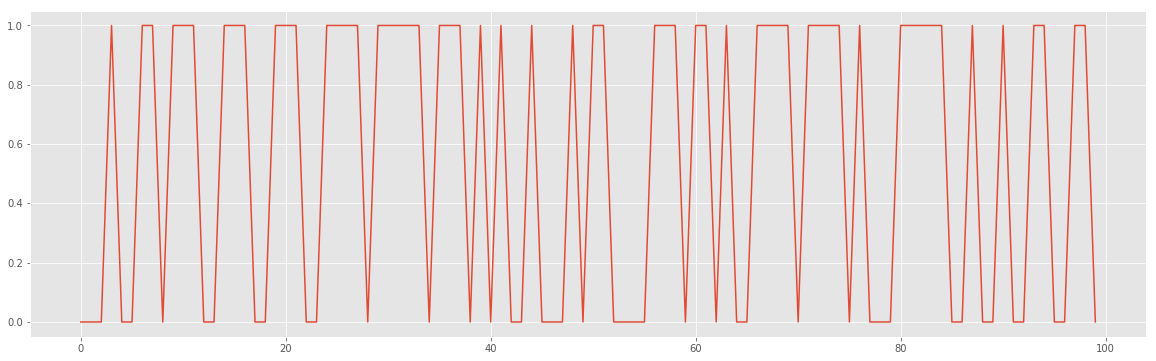

In [34]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])

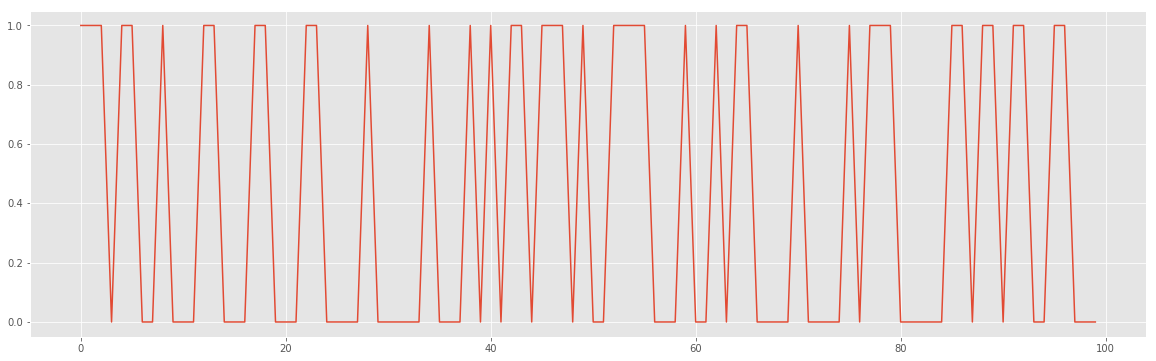

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(p2_mean_rwds[-100:])

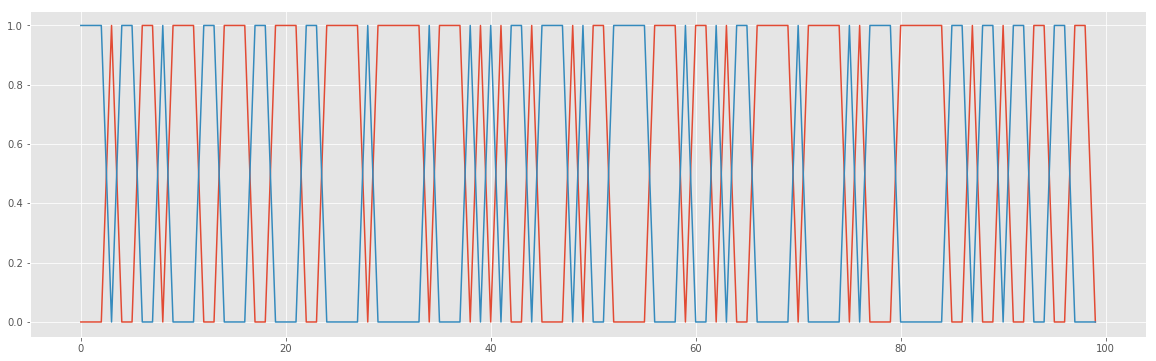

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])
plt.plot(p2_mean_rwds[-100:])

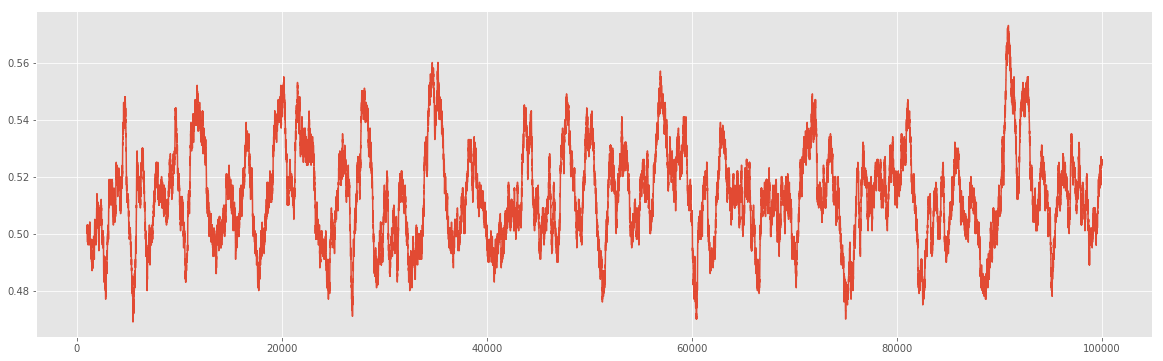

In [48]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds).rolling(1000, min_periods=1000).mean())

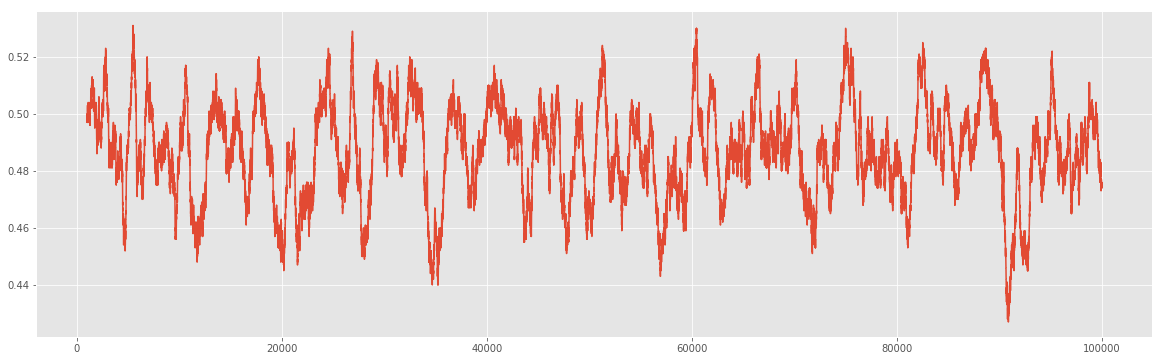

In [47]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p2_mean_rwds).rolling(1000, min_periods=1000).mean())

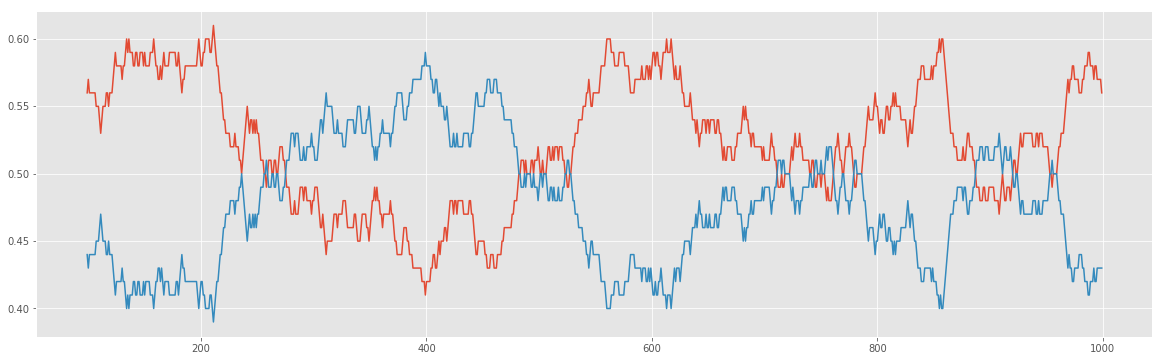

In [50]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())